In [11]:
import sys
sys.path.append('../')
import xgboost as xgb
import numpy as np
import importlib
import utils as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
importlib.reload(u)
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [89]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=100)
cases = datadict['cases_calibrated']
deaths = datadict['deaths_calibrated']

In [90]:
def transform(x):
    x0 = np.expand_dims(x[:, 0], axis=1)
    t = np.diff(x)
    t0 = np.expand_dims(t[:, 0], axis=1)
    t = np.diff(t)
    return t, t0, x0

In [141]:
def untransform(t, t0, x0, a=1):
    x = np.hstack([t0, t])
    x = np.cumsum(x, axis=a)
    x = np.hstack([x0, x])
    x = np.cumsum(x, axis=a)
    return x

In [92]:
deaths2, dt0, dx0 = transform(deaths)
cases2, ct0, cx0 = transform(cases)
d_orig = untransform(deaths2, dt0, dx0)

In [26]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

#     Print Summary
#     print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
#     print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
#     print(f' Significance Level    = {signif}')
#     print(f' Test Statistic        = {output["test_statistic"]}')
#     print(f' No. Lags Chosen       = {output["n_lags"]}')

#     for key,val in r[4].items():
#         print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    
    return p_value

In [28]:
pvals = []
for i, s in enumerate(deaths2):
    if np.all(np.isnan(s)):
        continue
    p = adfuller_test(pd.Series(s).fillna(0))
    pvals.append(p)
    print('\n')

 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value =

(3142, 93)


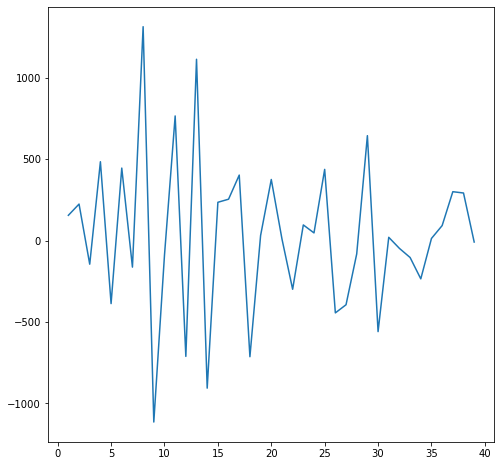

In [159]:
d = cases2
x1 = np.linspace(1, d.shape[1], d.shape[1])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x1, d[1868])
print(d.shape)
plt.show()

In [148]:
county = 1868
X = np.vstack([cases2[county], deaths2[county]])
s = np.argmax(np.isnan(X))
X = X[:, :s]

In [216]:
n = 25
X_train = X[:, :n].astype(int)
X_test = X[:, n:].astype(int)

In [217]:
print(X_train.shape, X_test.shape)

(2, 25) (2, 14)


In [218]:
model = VAR(X_train.T)
for i in range(9):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0
AIC :  21.8090533520912
BIC :  21.90656341808066
FPE :  2962024331.8821473
HQIC:  21.83609850023313 

Lag Order = 1
AIC :  20.232077194404646
BIC :  20.526590651991633
FPE :  613509342.9713632
HQIC:  20.31021169760792 

Lag Order = 2
AIC :  20.034081133596995
BIC :  20.527774270957494
FPE :  509113441.38025045
HQIC:  20.15824357385332 

Lag Order = 3
AIC :  20.190200367484458
BIC :  20.88450011053066
FPE :  614281808.6296906
HQIC:  20.353756509835776 

Lag Order = 4
AIC :  20.265816005496855
BIC :  21.16112095211693
FPE :  712372676.834942
HQIC:  20.460120097999685 

Lag Order = 5
AIC :  20.383357009984607
BIC :  21.478662510893997
FPE :  935771858.9389186
HQIC:  20.597172150787493 

Lag Order = 6
AIC :  20.688295272105535
BIC :  21.98068545412277
FPE :  1779157961.497099
HQIC:  20.907019039218603 

Lag Order = 7
AIC :  19.929374498319536
BIC :  21.413327428146477
FPE :  1951436706.0715427
HQIC:  20.133991597658458 

Lag Order = 8


c:\users\kehua\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:711: RuntimeWarning: divide by zero encountered in true_divide
  omega = sse / df_resid
c:\users\kehua\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1345: RuntimeWarning: invalid value encountered in multiply
  return self.sigma_u * self.df_resid / self.nobs


ValueError: array must not contain infs or NaNs

In [234]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 26, Apr, 2020
Time:                     21:48:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.5278
Nobs:                     23.0000    HQIC:                   20.1582
Log likelihood:          -285.663    FPE:                5.09113e+08
AIC:                      20.0341    Det(Omega_mle):     3.43522e+08
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       180.320256       109.814933            1.642           0.101
L1.y1        -0.963621         0.221886           -4.343           0.000
L1.y2        -1.732118         2.461208           -0.704           0.482
L2.y1        -0.405625

In [235]:
forecast_input = X_train[-9:].T
fc = model_fitted.forecast(y=forecast_input, steps=14)

In [236]:
fc = fc.astype(int)
fc

array([[-1249,   117],
       [ 2301,   164],
       [-2380,  -387],
       [ 1419,   486],
       [  798,  -317],
       [-2955,   -23],
       [ 4270,   458],
       [-3418,  -712],
       [  774,   679],
       [ 3070,  -248],
       [-5930,  -373],
       [ 6492,   966],
       [-3548, -1146],
       [-1698,   793]])

In [237]:
forecast_input

array([[  155,     0],
       [  224,     0],
       [ -145,     0],
       [  484,     0],
       [ -387,    21],
       [  445,    -2],
       [ -163,     1],
       [ 1313,    12],
       [-1114,     0],
       [  -90,    -7],
       [  765,    42],
       [ -711,   -30],
       [ 1113,    15],
       [ -906,    19],
       [  235,     0],
       [  254,   -19],
       [  402,    39],
       [ -713,     4],
       [   31,    33],
       [  375,     7],
       [   10,    46],
       [ -299,    34],
       [   96,  -159],
       [   47,   303],
       [  437,  -270]])

In [238]:
predictions = np.vstack([forecast_input, fc]).T
cases_predictions = predictions[0]
deaths_predictions = predictions[1]

In [239]:
cases_predictions = untransform(cases_predictions, ct0[county], cx0[county], 0)
deaths_predictions = untransform(deaths_predictions, dt0[county], dx0[county], 0)

(41,)


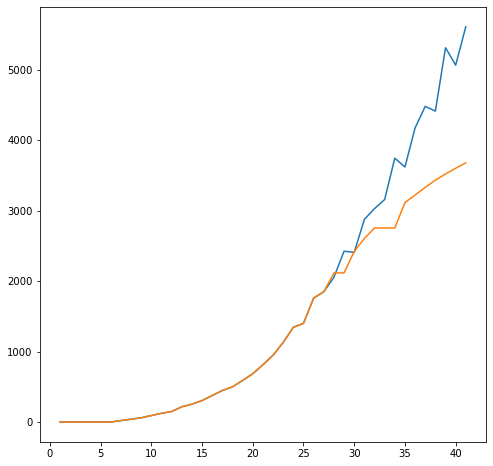

In [240]:
d = deaths_predictions
x1 = np.linspace(1, d.shape[0], d.shape[0])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x1, d)
d2 = deaths[county]
x2 = np.linspace(1, d2.shape[0], d2.shape[0])
plt.plot(x2, d2)
print(d.shape)
plt.show()